In [2]:

from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# ---------- Data ----------
with open('data_small.txt', 'r') as f:
    data = f.readlines()

CVRPTW = []
i = 0
for line in data:
    i=i+1
    words = line.split()
    words=[int(i) for i in words]
    CVRPTW.append(words)

CVRPTW = np.array(CVRPTW)

Nodes = CVRPTW[:,0]                 # nodes
n = len(Nodes)                      # number of nodes

Vehicles = {0, 1, 2, 3}



xcoord = CVRPTW[:,1]            # x coordinates
ycoord = CVRPTW[:,2]            # y coordinates
q = CVRPTW[:,3]                 # demand
service_duration = CVRPTW[:,4]                 # service time
earliest_time = CVRPTW[:,5]                 # ready time
latest_time = CVRPTW[:,6]                 # due date
Q = 130                         # vehicle capacity
BIGM = 12345                      # big M

# distance matrix   
distance = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        distance[i,j] = math.sqrt((xcoord[i]-xcoord[j])**2 + (ycoord[i]-ycoord[j])**2) 
    


# ---------- Optimization Model ----------

m = Model("CVRPTW")

# Variables
# if arc (i,j) is used in the solution by vehicle v
edge = {}
for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            edge[i,j,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='X_%s_%s_%s' % (i, j, v))

# time vehicle v starts service at node i
service_start = {}
for i in Nodes:
    for v in Vehicles:
        service_start[i,v] = m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name='t_%s_%s' % (i, v))

# if node i is visited by vehicle v
z = {}
for i in Nodes:
    for v in Vehicles:
        z[i,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='z_%s_%s' % (i, v))

use_vehicle = {v: m.addVar(vtype=GRB.BINARY, name=f'use_vehicle_{v}') for v in Vehicles}


m.update()

# Objective Function
C = 1000  # Penalty cost for using a vehicle
obj = quicksum(distance[i, j] * edge[i, j, v] for i in Nodes for j in Nodes for v in Vehicles) 
m.setObjective(obj)

m.ModelSense = GRB.MINIMIZE
m.update()

# Constraints

# each node is visited by exactly one vehicle 
con0 = {}
for v in Vehicles:
    for i in Nodes:
        con0[i,v] = m.addConstr(
            edge[i,i,v] == 0, 'con0[' + str(i) + ',' + str(j) + ']'
        )

# relation between edge
con1 = {}
for i in Nodes:
    for v in Vehicles:
        con1[i,v] = m.addConstr(
            quicksum(edge[i,j,v] for j in Nodes) == z[i,v], 'con12[' + str(i) + ',' + str(v) + ']'
        )



con11 = {}
for i in Nodes:
    if i != 0:
        con11[i] = m.addConstr(
            quicksum(z[i,v] for v in Vehicles) == 1, 'con11[' + str(i) + ']'
        )

    
# each vehicle starts and ends at the depot
con2 = {}
con3 = {}
for v in Vehicles:
    con2[v] = m.addConstr(
        quicksum(edge[0, i, v] for i in Nodes if i != 0) <= 1, 'con2[' + str(v) + ']'
    )
    con3[v] = m.addConstr(
        quicksum(edge[i, 0, v] for i in Nodes if i != 0) <= 1, 'con3[' + str(v) + ']'
    )



# Capacity constraint
con4 = {}
for v in Vehicles:
    con4[v] = m.addConstr(
        quicksum(q[i]*z[i,v] for i in Nodes) <= Q, 'con4[' + str(v) + ']'
    )


# Flow conservation excluding self-loops
con5 = {}
for i in Nodes:
    for v in Vehicles:
        con5[i, v] = m.addConstr(
            quicksum(edge[i, j, v] for j in Nodes) == quicksum(edge[j, i, v] for j in Nodes),
            'con5[' + str(i) + ',' + str(v) + ']'
        )


# time window constraints
con6 = {}
con7 = {}
con8 = {}
for i in Nodes:
    for v in Vehicles:
        con6[i,v] = m.addConstr(
            service_start[i,v] >= earliest_time[i], 'con6[' + str(i) + ',' + str(v) + ']'
            )
        con7[i,v] = m.addConstr(
            service_start[i,v] <= latest_time[i], 'con7[' + str(i) + ',' + str(v) + ']'
            )

for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            if i != j and i != 0 and j != 0:
                con8[i,j,v] = m.addConstr(
                    service_start[j,v] >= service_start[i,v] + service_duration[i] + distance[i,j] - BIGM*(1-edge[i,j,v]), 'con8[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
                    )


# Solve
m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 3600
m.optimize()



Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 424 rows, 400 columns and 1844 nonzeros
Model fingerprint: 0xd02aab72
Variable types: 36 continuous, 364 integer (364 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 333 rows and 194 columns
Presolve time: 0.01s
Presolved: 91 rows, 206 columns, 715 nonzeros
Variable types: 12 continuous, 194 integer (194 binary)
Found heuristic solution: objective 269.4747840

Root relaxation: objective 1.255986e+02, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

C:\Users\kai-s\AppData\Local\Temp\ipykernel_4728\3852006493.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors


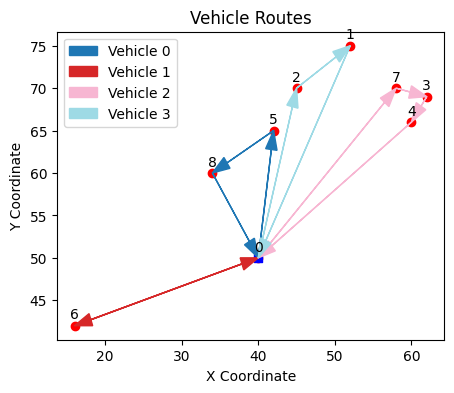

In [31]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    # create list of dynamic length, depending on len(Vehicles) with different colors
    num_vehicles = len(Vehicles)

    # Generate distinct colors using a colormap
    cmap = plt.cm.get_cmap('tab20', num_vehicles)  # Use 'tab20' for up to 20 distinct colors
    colors = [cmap(i) for i in range(num_vehicles)]  # Extract `num_vehicles` colors
     
    for v in Vehicles:
        for (i, j) in routes[v]:
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")


In [19]:
# Create a dataframe to store the results for all vehicles
df_all = pd.DataFrame(columns=['Vehicle', 'Node', 'Service Start', 'Load'])

for v in Vehicles:
    if not routes[v]:
        print(f"Vehicle {v} is not used.")
    else:
        print(f"Vehicle {v} service times and loads:")
        sorted_routes = sorted(routes[v], key=lambda x: service_start[x[0], v].X)
        load = 0
        for (i, j) in sorted_routes:
            load += q[i]
            print(f"  Node {i}: Service start at {service_start[i, v].X:.2f}, Load: {load}")
            new_row = pd.DataFrame({'Vehicle': [v], 'Node': [i], 'Service Start': [service_start[i, v].X], 'Load': [load]})
            if not new_row.isna().all(axis=None):
                df_all = pd.concat([df_all, new_row], ignore_index=True)

        print("\n")

df_all
# show the total distance traveled by all vehicles
total_distance = 0
for v in Vehicles:
    for (i, j) in routes[v]:
        total_distance += distance[i, j]
print(f"Total distance traveled by all vehicles: {total_distance:.2f}")

Vehicle 0 service times and loads:
  Node 0: Service start at 0.00, Load: 0
  Node 5: Service start at 25.00, Load: 10
  Node 2: Service start at 302.40, Load: 40
  Node 1: Service start at 311.00, Load: 50
  Node 7: Service start at 1162.88, Load: 70
  Node 3: Service start at 1257.39, Load: 80
  Node 4: Service start at 1261.00, Load: 90


Vehicle 1 is not used.
Vehicle 2 service times and loads:
  Node 0: Service start at 0.00, Load: 0
  Node 6: Service start at 657.00, Load: 20
  Node 8: Service start at 2887.00, Load: 40


Vehicle 3 is not used.
Vehicle 4 is not used.
Vehicle 5 is not used.
Vehicle 6 is not used.
Vehicle 7 is not used.
Vehicle 8 is not used.
Vehicle 9 is not used.
Total distance traveled by all vehicles: 133.13


C:\Users\kai-s\AppData\Local\Temp\ipykernel_4728\4211352367.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, new_row], ignore_index=True)
